In [1]:
!pip install pandas_datareader
!pip install fix_yahoo_finance
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.3 MB 7.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [5]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
from google.colab import data_table

data_table.enable_dataframe_formatter()

In [40]:
def visualize_signals(signals):
  # Initialize the plot figure
  fig = plt.figure( figsize=(8, 6))

  # Add a subplot and label for y-axis
  ax1 = fig.add_subplot(111,  ylabel='Price in $')

  # Plot the closing price
  # aapl['Close'].plot(ax=ax1, color='r', lw=2.)

  # Plot the short and long moving averages
  signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

  # Plot the buy signals
  ax1.plot(signals.loc[signals.positions == 1.0].index, 
          signals.short_mavg[signals.positions == 1.0],
          '^', markersize=10, color='m')
          
  # Plot the sell signals
  ax1.plot(signals.loc[signals.positions == -1.0].index, 
          signals.short_mavg[signals.positions == -1.0],
          'v', markersize=10, color='k')
          
  # Show the plot
  plt.show()

def load_ticker(ticker):
  yf.pdr_override()
  stock = pdr.get_data_yahoo(ticker, 
                            start=datetime.datetime(2006, 10, 1), 
                            end=datetime.datetime(2021, 12, 5))
  return stock

def ma_strategy(stock, short_window=40, long_window=100):
  # Initialize the short and long windows# Initia 

  # Initialize the `signals` DataFrame with the `signal` column
  signals = pd.DataFrame(index=stock.index)
  signals['signal'] = 0.0

  # Create short simple moving average over the short window
  signals['short_mavg'] = stock['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

  # Create long simple moving average over the long window
  signals['long_mavg'] = stock['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

  # Create signals
  signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                              > signals['long_mavg'][short_window:], 1.0, 0.0)   

  # Generate trading orders
  signals['positions'] = signals['signal'].diff()
  return signals

def portfolio_evaluation(signals, stock):
  np.where(signals.signal.diff() == 1)
  np.where(signals.signal.diff() == -1)
  buy_mask = np.where(signals.signal.diff() == 1)[0]
  sell_mask = np.where(signals.signal.diff() == -1)[0]
  np.array(stock['Adj Close'][buy_mask])
  np.array(stock['Adj Close'][sell_mask])
  buy_close = np.array(stock['Adj Close'][buy_mask])
  sell_close = np.array(stock['Adj Close'][sell_mask])
  if (sell_close.shape[0] < buy_close.shape[0]):
    sell_close = np.append(sell_close, stock['Adj Close'].loc['2021-12-03'])
  return (sell_close / buy_close).prod()

def tune_strategy_param(stock, short_window=40, long_window=100):
  signals = ma_strategy(stock, short_window, long_window)
  return portfolio_evaluation(signals, stock)

def init_param_list(short_window_max=100, long_window_max=100):
  param_list = []
  for short_window in np.arange(1, short_window_max):
    for long_window in np.arange(1, long_window_max):
      param_list.append((short_window, long_window))
  return param_list

def evaluate_strategy_performance(stock, param_list):
  return list(map(lambda param : _map_to_strategy_performance(param, stock), param_list))

def visualize_strategy_perf(strategy_perf_mat):
  x = np.array(strategy_perf_mat)[:,0]
  y = np.array(strategy_perf_mat)[:,1]
  z = np.array(strategy_perf_mat)[:,2]
  df = pd.DataFrame.from_dict(np.array([x,y,z]).T)
  df.columns = ['X_value','Y_value','Z_value']
  df['Z_value'] = pd.to_numeric(df['Z_value'])
  pivotted= df.pivot('Y_value','X_value','Z_value')
  ax = sns.heatmap(pivotted,cmap='RdBu')
  ax.invert_yaxis()
  
def draw_stock(stock):
  # Plot the closing prices for `aapl`
  stock['Adj Close'].plot(grid=True)

  # Show the plot
  plt.show()

def draw_stocks(*stocks):
  # Plot the closing prices
  for stock in stocks:
    stock['Adj Close'].plot(grid=True)

  # Show the plot
  plt.show()

def _map_to_strategy_performance(param, stock):
   return (param[0], param[1], tune_strategy_param(stock, param[0], param[1]))

In [67]:
xlk = load_ticker("XLK")
spy = load_ticker("SPY")
qqq = load_ticker("QQQ")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


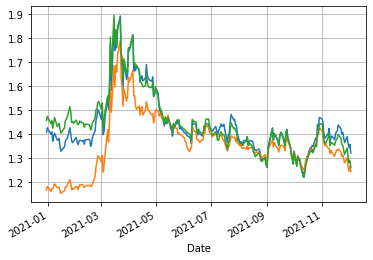

In [68]:
xlk_2020 = xlk.loc["2020-1-1":"2021-12-7"]
spy_2020 = spy.loc["2020-1-1":"2021-12-7"]
qqq_2020 = qqq.loc["2020-1-1":"2021-12-7"]
xlk_rolling_yty = xlk_2020.rolling(window=252).apply(lambda x: x[-1]/x[0])
spy_rolling_yty = spy_2020.rolling(window=252).apply(lambda x: x[-1]/x[0])
qqq_rolling_yty = qqq_2020.rolling(window=252).apply(lambda x: x[-1]/x[0])
draw_stocks(xlk_rolling_yty, spy_rolling_yty, qqq_rolling_yty)

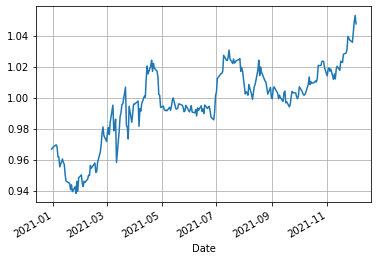

In [72]:
draw_stock(xlk_rolling_yty / qqq_rolling_yty)

In [61]:
xlk_rolling_yty.mean()

Open         1.423368
High         1.415409
Low          1.429937
Close        1.422592
Adj Close    1.436305
Volume       0.801032
dtype: float64

In [62]:
spy_rolling_yty.mean()

Open         1.338839
High         1.331884
Low          1.345758
Close        1.339026
Adj Close    1.360243
Volume       0.901359
dtype: float64

In [57]:
returns = xlk_rolling_yty - spy_rolling_yty
sharpe_ratio = (returns.mean() / returns.std())
sharpe_ratio['Adj Close']

1.0495562611159588

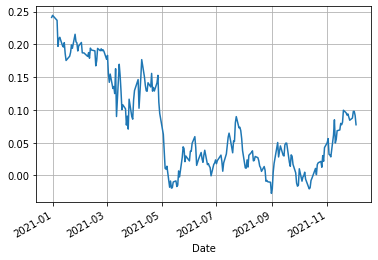

In [59]:
draw_stock(returns)